# Event Sequence Analysis Tutorial (LSOG / dyadic_children)

This tutorial demonstrates **event sequence analysis** in Sequenzo using the **LSOG dyadic_children** dataset. We cover:

1. **create_event_sequences** — Build event sequences from state sequences (transition or state method)
2. **EventSequenceConstraint** — Time constraints for subsequence search
3. **find_frequent_subsequences** — Discover frequent event patterns (min_support, constraint, str_subseq)
4. **count_subsequence_occurrences** — Presence/count matrix per sequence
5. **compare_groups** — Discriminating subsequences between groups (e.g. by sex)
6. **plot_event_sequences** — Index plot and parallel coordinates
7. **plot_subsequence_frequencies** — Bar chart of subsequence Support/Count

API aligns with **TraMineR** (`seqecreate`, `seqefsub`, `seqeapplysub`, `seqecmpgroup`, `plot.seqelist`, `plot.subseqelist`).

## 1. Load LSOG data and build SequenceData

We use **dyadic_children** (LSOG): state sequences with numeric time columns and `dyadID`. States are 1–6.

In [1]:
from sequenzo import SequenceData
from sequenzo.datasets import load_dataset
import pandas as pd

# Load dyadic_children (LSOG)
df = load_dataset("dyadic_children")
# Use a subset for faster demo (e.g. 50 rows)
df = df.head(50)

# Time columns are numeric (e.g. "1", "2", ...)
time_list = [c for c in df.columns if str(c).isdigit()]
time_list = sorted(time_list, key=int)
states = [1, 2, 3, 4, 5, 6]

seqdata = SequenceData(
    df,
    time=time_list,
    id_col="dyadID",
    states=states,
)
print(f"Sequences: {seqdata.seqdata.shape[0]}, time points: {len(time_list)}")
df.head()


[>] SequenceData initialized successfully! Here's a summary:
[>] Number of sequences: 50
[>] Number of time points: 25
[>] Min/Max sequence length: 25 / 25
[>] States: [1, 2, 3, 4, 5, 6]
[>] Labels: ['1', '2', '3', '4', '5', '6']
[>] Weights: Not provided
Sequences: 50, time points: 25


,dyadID,sex,15,16,17,18,19,20,21,22,...,30,31,32,33,34,35,36,37,38,39
0,16,1,1,1,1,1,1,3,3,4,...,4,4,4,4,4,4,4,4,4,4
1,19,1,1,1,1,1,1,1,1,1,...,3,3,4,4,4,4,4,4,4,4
2,26,1,1,1,1,1,2,3,3,3,...,6,6,4,4,4,4,4,4,4,4
3,29,0,1,1,1,1,1,1,1,1,...,3,3,3,3,3,3,3,4,4,4
4,31,0,1,1,1,2,3,3,3,3,...,6,6,6,6,6,6,6,6,6,6


## 2. Create event sequences (create_event_sequences)

Convert state sequences to **event sequences**. Two modes:

- **tevent="transition"**: one event per state change (e.g. "1>2", "2>3") — default, TraMineR-style.
- **tevent="state"**: one event per state entry.

In [2]:
from sequenzo.with_event_history_analysis import create_event_sequences

# Transition method: one event per transition (e.g. 1>2, 2>3)
eseq = create_event_sequences(data=seqdata, tevent="transition")
print(eseq)
print("Event alphabet (first 10):", eseq.dictionary[:10])
print("Example sequence:", eseq.sequences[0])

EventSequenceList(n=50, events=14)
Event alphabet (first 10): ['1', '1>2', '1>3', '2>3', '2>6', '3>4', '3>6', '4>5', '4>6', '5>6']
Example sequence: EventSequence(id=16, events=[0.0:1, 6.0:1>3, 8.0:3>4])


In [3]:
# Optional: state method (one event per state entry)
eseq_state = create_event_sequences(data=seqdata, tevent="state")
print("State method:", eseq_state)
print("Example:", eseq_state.sequences[0])

State method: EventSequenceList(n=50, events=6)
Example: EventSequence(id=16, events=[0.0:1, 6.0:3, 8.0:4])


## 3. Find frequent subsequences (find_frequent_subsequences)

Discover event patterns that appear in at least **min_support** sequences (or **pmin_support** proportion). Optional **EventSequenceConstraint** limits time gaps and windows.

In [4]:
from sequenzo.with_event_history_analysis import find_frequent_subsequences

# Minimum support = at least 2 sequences must contain the pattern
fsub = find_frequent_subsequences(eseq, min_support=2)
print(fsub)
print(fsub.data.head(10))

SubsequenceList(n=114, type=frequent)
   Support  Count
0     1.00   50.0
1     0.74   37.0
2     0.74   37.0
3     0.74   37.0
4     0.60   30.0
5     0.60   30.0
6     0.60   30.0
7     0.60   30.0
8     0.60   30.0
9     0.56   28.0


### 3.1 With EventSequenceConstraint

Constrain **max_gap**, **window_size**, **age_min**, **age_max** to focus on specific time windows.

In [5]:
from sequenzo.with_event_history_analysis import EventSequenceConstraint

constraint = EventSequenceConstraint(
    max_gap=5.0,      # max time between consecutive events in a subsequence
    window_size=15.0, # max total time window for the subsequence
    age_min=0,
    age_max=50,
    count_method=1,   # COBJ: count per sequence (presence)
)
fsub_constrained = find_frequent_subsequences(eseq, min_support=2, constraint=constraint)
print("With constraint:", fsub_constrained)
print(fsub_constrained.data.head())

With constraint: SubsequenceList(n=56, type=frequent)
   Support  Count
0     1.00   50.0
1     0.74   37.0
2     0.60   30.0
3     0.56   28.0
4     0.50   25.0


### 3.2 Search for specific subsequences (str_subseq)

Find support/count for **given** patterns (string format: transitions separated by `-`, e.g. `(1>2)-(2>3)`).

In [6]:
# Use first few transition labels from the alphabet
sample_transitions = eseq.dictionary[:5]
# Build pattern strings like "(1>2)-(2>3)" from alphabet labels
str_subseq = [f"({sample_transitions[0]})-({sample_transitions[1]})"]
if len(sample_transitions) >= 3:
    str_subseq.append(f"({sample_transitions[0]})-({sample_transitions[2]})")
print("Searching for:", str_subseq)
fsub_specific = find_frequent_subsequences(eseq, str_subseq=str_subseq)
print(fsub_specific)
print(fsub_specific.data)

Searching for: ['(1)-(1>2)', '(1)-(1>3)']
SubsequenceList(n=2, type=user)
   Support  Count
0     0.74   37.0
1     0.14    7.0


## 4. Count subsequence occurrences (count_subsequence_occurrences)

Build a matrix: rows = sequences, columns = subsequences.  
- **method="presence"** (COBJ): 0/1 per sequence.  
- **method="count"** (CDIST_O): number of distinct occurrences per sequence.

In [7]:
from sequenzo.with_event_history_analysis import count_subsequence_occurrences
import numpy as np

# Presence: 1 if sequence contains the pattern, else 0
presence = count_subsequence_occurrences(fsub, method="presence")
print("Presence matrix shape:", presence.shape)
print("Values in {0, 1}:", np.unique(presence))

# Count: number of times each pattern appears in each sequence
counts = count_subsequence_occurrences(fsub, method="count")
print("Count matrix shape:", counts.shape)
print("Sample row (first sequence):", counts[0, :5])

Presence matrix shape: (50, 114)
Values in {0, 1}: [0. 1.]
Count matrix shape: (50, 114)
Sample row (first sequence): [1. 0. 0. 0. 0.]


## 5. Compare groups (compare_groups)

Find subsequences that **discriminate** between groups (e.g. by **sex**). Uses chi-square test; optional **pvalue_limit** to filter by significance.

In [8]:
from sequenzo.with_event_history_analysis import compare_groups

# Group by sex (0/1 in dyadic_children); must match order of sequences in eseq
group = df["sex"].values
discr = compare_groups(fsub, group, method="chisq", pvalue_limit=1.0)
print("Discriminating subsequences (all with p-value <= 1.0):", len(discr))
if len(discr) > 0:
    print(discr.data.head(10))

Discriminating subsequences (all with p-value <= 1.0): 114
    p.value  statistic  index  Support  Freq.0   Resid.0    Freq.1   Resid.1
0  0.074891   3.172426     51     0.12     0.0 -1.587451  0.206897  1.350862
1  0.074891   3.172426     52     0.12     0.0 -1.587451  0.206897  1.350862
2  0.074891   3.172426     48     0.12     0.0 -1.587451  0.206897  1.350862
3  0.074891   3.172426     41     0.12     0.0 -1.587451  0.206897  1.350862
4  0.074891   3.172426     42     0.12     0.0 -1.587451  0.206897  1.350862
5  0.074891   3.172426     39     0.12     0.0 -1.587451  0.206897  1.350862
6  0.074891   3.172426     49     0.12     0.0 -1.587451  0.206897  1.350862
7  0.074891   3.172426     50     0.12     0.0 -1.587451  0.206897  1.350862
8  0.074891   3.172426     38     0.12     0.0 -1.587451  0.206897  1.350862
9  0.074891   3.172426     37     0.12     0.0 -1.587451  0.206897  1.350862


## 6. Plot event sequences (plot_event_sequences)

- **type="index"**: index plot (time on x-axis, one row per sequence).  
- **type="parallel"**: parallel coordinates (normalized time vs sequence index).

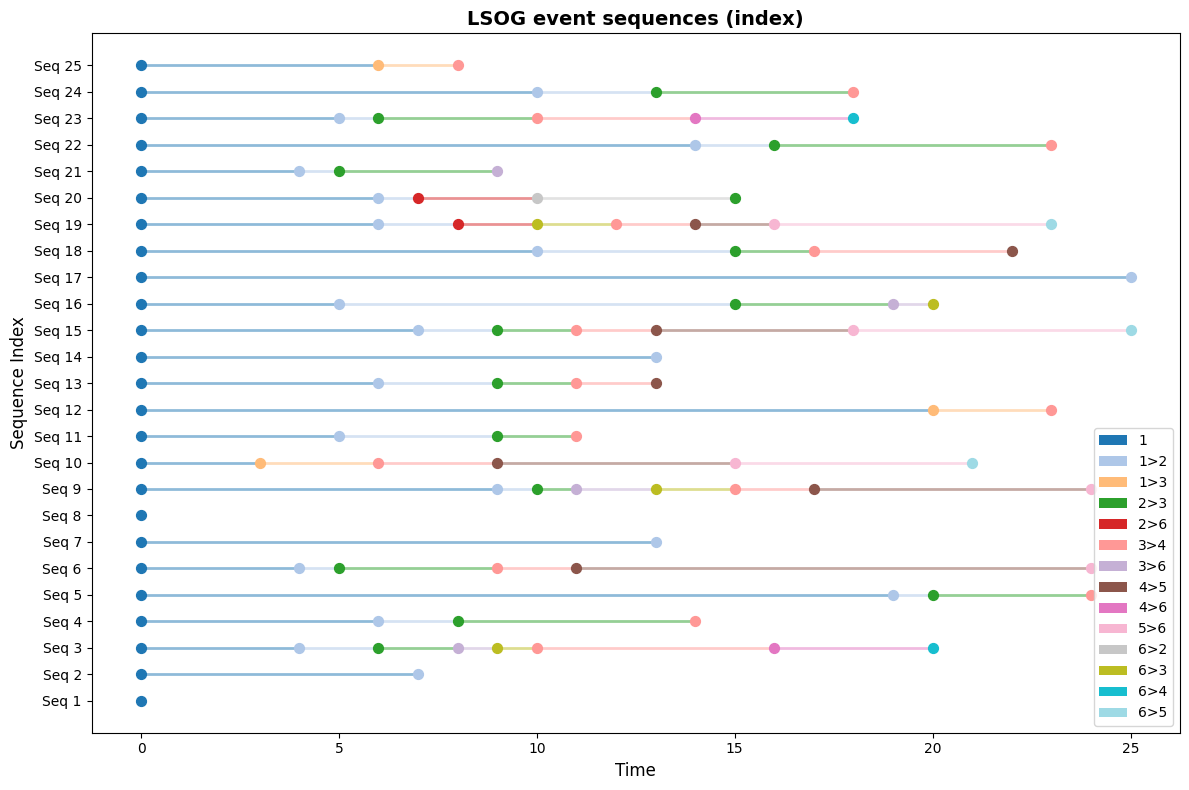

In [9]:
from sequenzo.with_event_history_analysis import plot_event_sequences
import matplotlib.pyplot as plt

# Index plot (show first 25 sequences)
fig1 = plot_event_sequences(eseq, type="index", top_n=25, title="LSOG event sequences (index)")
plt.show()

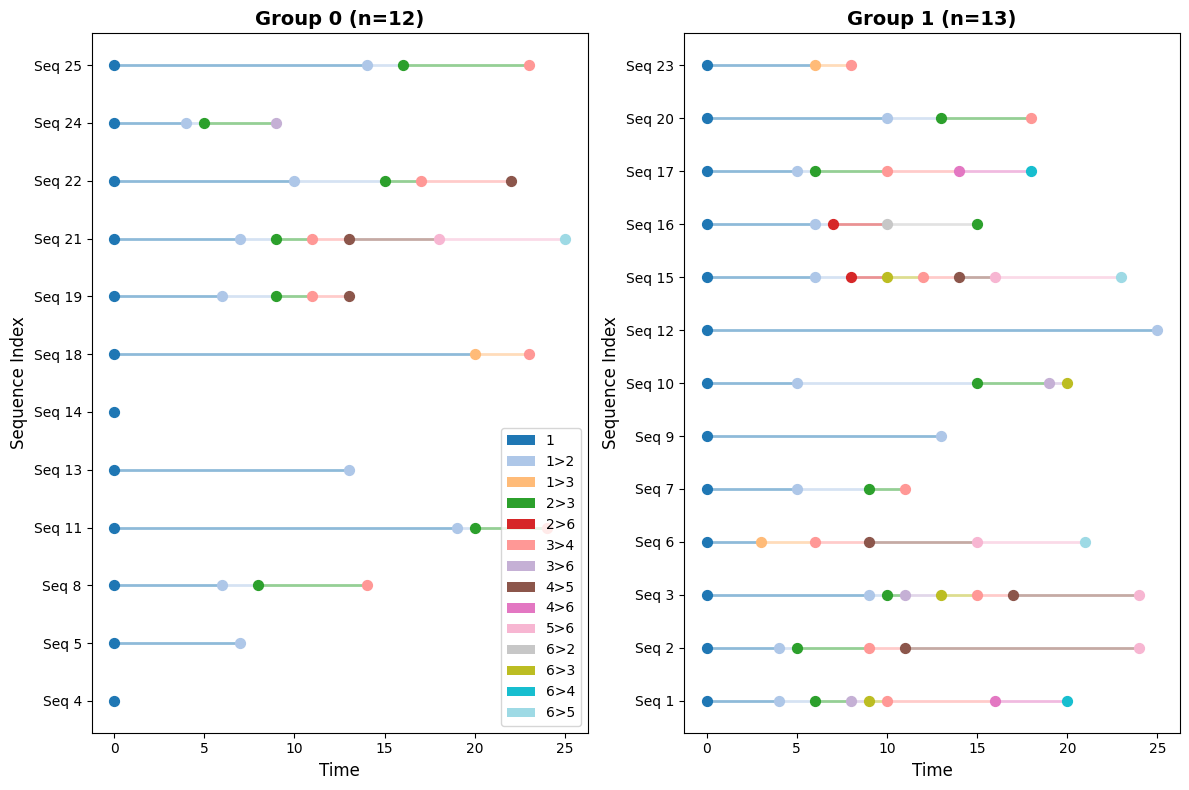

In [10]:
# Optional: color by group (sex)
fig2 = plot_event_sequences(eseq, type="index", group=df["sex"].values, top_n=25, title="LSOG by sex")
plt.show()

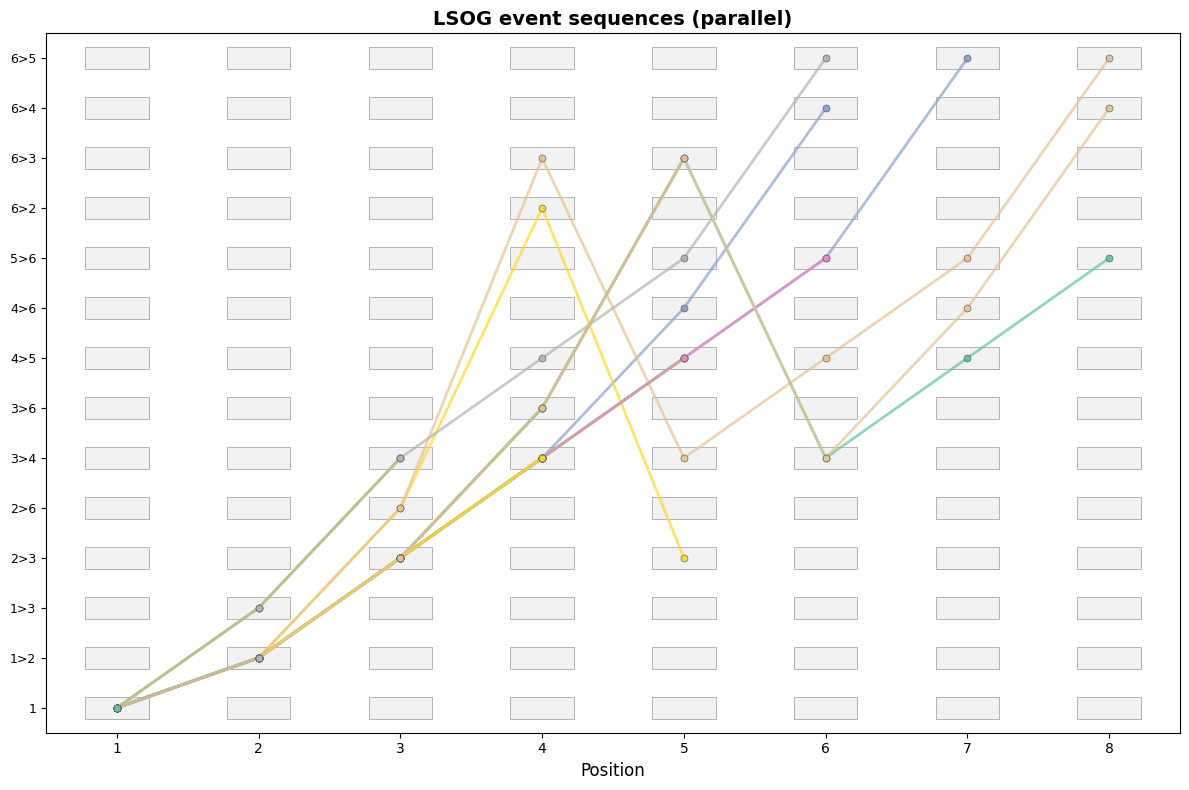

In [11]:
# Parallel coordinates plot
fig3 = plot_event_sequences(eseq, type="parallel", top_n=25, title="LSOG event sequences (parallel)")
plt.show()

## 7. Plot subsequence frequencies (plot_subsequence_frequencies)

Bar chart of **Support** (or **Count**) for the top frequent subsequences.

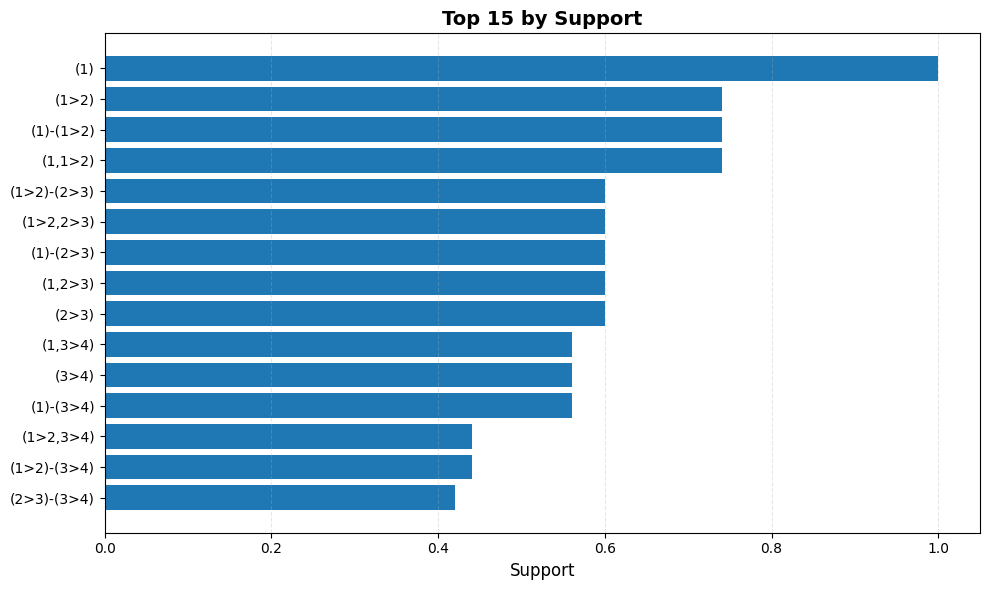

In [12]:
from sequenzo.with_event_history_analysis import plot_subsequence_frequencies

# By Support (proportion of sequences)
fig4 = plot_subsequence_frequencies(fsub, top_n=15, use_count=False, title="Top 15 by Support")
plt.show()

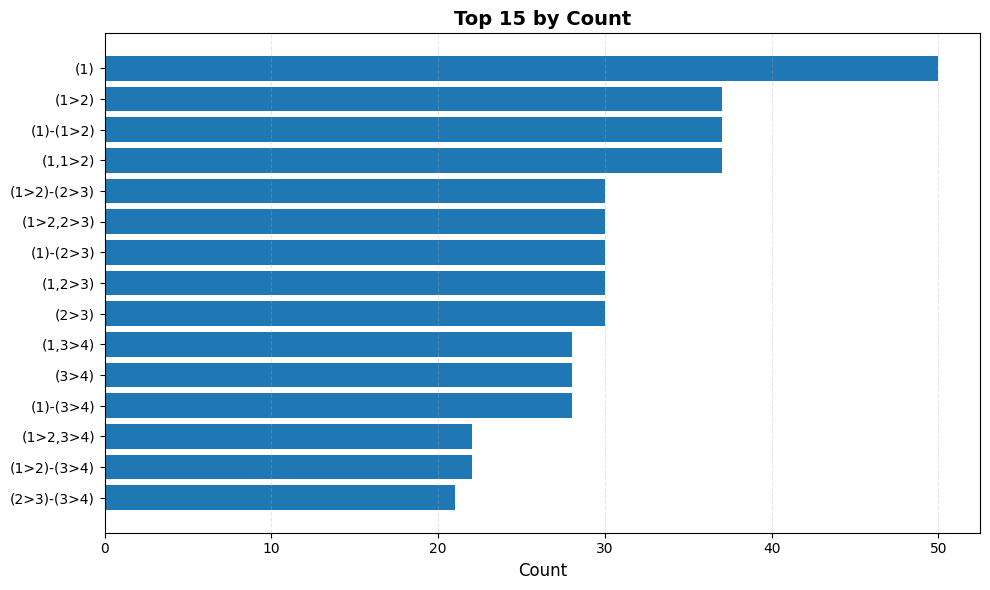

In [13]:
# By Count (number of sequences)
fig5 = plot_subsequence_frequencies(fsub, top_n=15, use_count=True, title="Top 15 by Count")
plt.show()

## Summary

| Function | TraMineR | Description |
|----------|----------|-------------|
| `create_event_sequences` | seqecreate | State → event sequences (transition/state) |
| `EventSequenceConstraint` | seqeconstraint | max_gap, window_size, age_min/max, count_method |
| `find_frequent_subsequences` | seqefsub | min_support, pmin_support, constraint, str_subseq |
| `count_subsequence_occurrences` | seqeapplysub | presence / count matrix |
| `compare_groups` | seqecmpgroup | Discriminating subsequences (chisq) |
| `plot_event_sequences` | plot.seqelist | index / parallel |
| `plot_subsequence_frequencies` | plot.subseqelist | Support or Count bar chart |